In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torchsummary import summary

In [7]:
df = pd.read_csv("C:/Users/하태권/Downloads/diabetes.csv") #데이터 로딩
df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


In [9]:
df.columns


Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'],
      dtype='object')

In [11]:
df.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

<Axes: ylabel='count'>

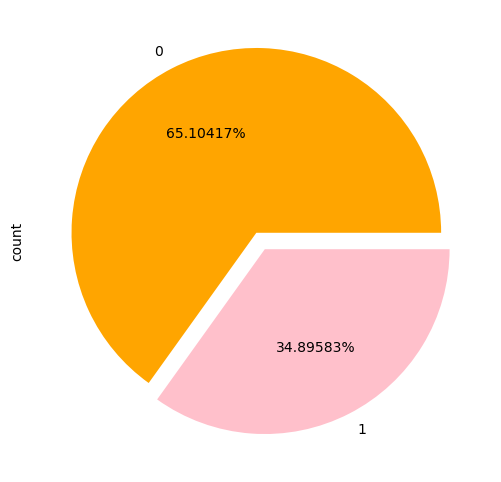

In [15]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 8
fig_size[1] = 6
plt.rcParams["figure.figsize"] = fig_size
df.Outcome.value_counts().plot(kind='pie', autopct='%0.05f%%', colors=['orange', 'pink'], explode=(0.05, 0.05))

In [19]:

# 데이터와 타겟 분리
X = df.drop('Outcome', axis=1).values
y = df['Outcome'].values

In [21]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

X_train.shape, X_test.shape, y_train.shape, y_test.shape, 

((614, 8), (154, 8), (614,), (154,))

In [23]:
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

In [25]:
train_dataset = TensorDataset(X_train, y_train)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

test_dataset = TensorDataset(X_test, y_test)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([614, 8]),
 torch.Size([154, 8]),
 torch.Size([614, 1]),
 torch.Size([154, 1]))

In [27]:
class DiabetesDense(nn.Module):
    def __init__(self):
        super(DiabetesDense, self).__init__()
        self.fc1 = nn.Linear(8, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)  
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = DiabetesDense()

In [29]:
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [31]:
# 손실 값과 정확도를 저장할 리스트
train_losses = []
test_accuracies = []

# 에폭 수만큼 학습 반복
num_epochs = 20
for epoch in range(num_epochs):
    model.train()  # 모델을 학습 모드로 설정 (Dropout, BatchNorm 등을 활성화)
    running_loss = 0.0  # 에폭 동안의 누적 손실 초기화

    # 학습 데이터셋에 대해 반복
    for inputs, labels in train_dataloader:
        optimizer.zero_grad()         # 누적된 그래디언트 초기화
        outputs = model(inputs)       # 순전파 수행
        loss = criterion(outputs, labels)  # 손실 함수 계산
        loss.backward()              # 역전파 수행
        optimizer.step()             # 가중치 업데이트
        running_loss += loss.item()  # 손실 누적

    # 에폭별 평균 손실 저장
    train_losses.append(running_loss / len(train_dataloader))

    # 테스트 정확도 평가
    model.eval()  # 모델을 평가 모드로 설정 (Dropout 등 비활성화)
    correct = 0
    total = 0
    with torch.no_grad():  # 평가 시 그래디언트 계산 생략 (속도 향상, 메모리 절약)
        for inputs, labels in test_dataloader:
            outputs = model(inputs)  # 순전파 수행
            predicted = (torch.sigmoid(outputs) >= 0.5).float()  # 확률 → 클래스 변환 (이진 분류)
            total += labels.size(0)  # 전체 샘플 수 증가
            correct += (predicted == labels).sum().item()  # 정답 맞춘 개수 누적

    # 정확도 계산 및 저장
    accuracy = 100 * correct / total
    test_accuracies.append(accuracy)

    # 에폭별 학습 결과 출력
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {train_losses[-1]:.4f}, Accuracy: {accuracy:.2f}%")

# 학습 완료 메시지
print("Training complete.")

Epoch 1/20, Loss: 0.6557, Accuracy: 74.03%
Epoch 2/20, Loss: 0.6068, Accuracy: 76.62%
Epoch 3/20, Loss: 0.5634, Accuracy: 78.57%
Epoch 4/20, Loss: 0.5112, Accuracy: 77.92%
Epoch 5/20, Loss: 0.4888, Accuracy: 81.17%
Epoch 6/20, Loss: 0.4838, Accuracy: 79.87%
Epoch 7/20, Loss: 0.4851, Accuracy: 80.52%
Epoch 8/20, Loss: 0.4657, Accuracy: 80.52%
Epoch 9/20, Loss: 0.4796, Accuracy: 81.17%
Epoch 10/20, Loss: 0.4495, Accuracy: 79.87%
Epoch 11/20, Loss: 0.4623, Accuracy: 79.87%
Epoch 12/20, Loss: 0.4523, Accuracy: 80.52%
Epoch 13/20, Loss: 0.4553, Accuracy: 80.52%
Epoch 14/20, Loss: 0.4762, Accuracy: 81.17%
Epoch 15/20, Loss: 0.4435, Accuracy: 81.17%
Epoch 16/20, Loss: 0.4419, Accuracy: 80.52%
Epoch 17/20, Loss: 0.4274, Accuracy: 80.52%
Epoch 18/20, Loss: 0.4319, Accuracy: 80.52%
Epoch 19/20, Loss: 0.4390, Accuracy: 79.22%
Epoch 20/20, Loss: 0.4292, Accuracy: 79.87%
Training complete.


In [33]:
# 모델 평가
model.eval()

# 실제 라벨과 예측값 저장용 리스트
all_labels = []
all_predictions = []

with torch.no_grad():
    for inputs, labels in test_dataloader:
        outputs = model(inputs)  # 순전파 수행
        _, predicted = torch.max(outputs.data, 1)  # 확률이 가장 높은 클래스 선택
        all_labels.extend(labels.cpu().numpy())       # 실제 정답 저장
        all_predictions.extend(predicted.cpu().numpy())  # 예측 결과 저장

# 리스트를 numpy 배열로 변환 (scikit-learn 사용을 위함)
all_labels = np.array(all_labels)
all_predictions = np.array(all_predictions)

# 평가 지표 계산
conf_matrix = confusion_matrix(all_labels, all_predictions)  # 혼동 행렬
f1 = f1_score(all_labels, all_predictions, average='weighted')  # F1 점수 (클래스 불균형 고려)
precision = precision_score(all_labels, all_predictions, average='weighted')  # 정밀도
recall = recall_score(all_labels, all_predictions, average='weighted')  # 재현율

# 클래스별 Specificity 계산
specificity = []
for i in range(conf_matrix.shape[0]):
    tn = conf_matrix.sum() - (conf_matrix[i, :].sum() + conf_matrix[:, i].sum() - conf_matrix[i, i])  # True Negative
    fp = conf_matrix[:, i].sum() - conf_matrix[i, i]  # False Positive
    specificity.append(tn / (tn + fp))  # Specificity = TN / (TN + FP)

# 결과 출력
print(f'Confusion Matrix:\n{conf_matrix}')
print(f'F1 Score: {f1:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'Specificity: {np.mean(specificity):.2f}')  # 평균 Specificity 출력

Confusion Matrix:
[[107   0]
 [ 47   0]]
F1 Score: 0.57
Precision: 0.48
Recall: 0.69
Specificity: 0.50


C:\Userai\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


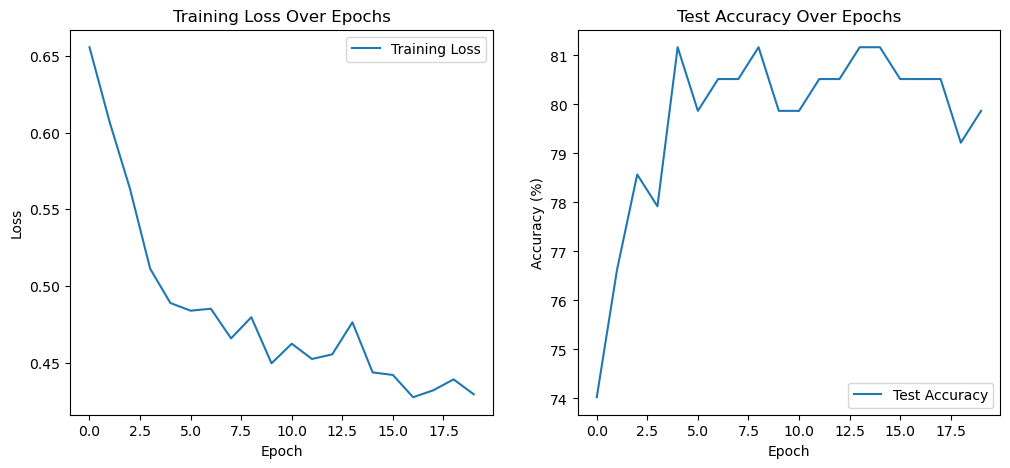

In [35]:
# Plot the loss and accuracy
plt.figure(figsize=(12, 5))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Test Accuracy Over Epochs')
plt.legend()

plt.show()